# Семинар 1

Сегодня мы с вами познакомимся с задачей абстактивной суммаризации, в частности попробуем реализовать сначала реализацию на основе статистических методов и реализуем суммаризацию на основе графового метода (PageRank)

Для удобства будем использовать датасет с новостями Lenta.ru, который мы использовали на первой неделе

In [9]:
import re
from string import punctuation
from heapq import nlargest

from  tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from wordcloud import WordCloud

import nltk
nltk.download('punkt') # one time execution
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize

russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это', 'нею'])

[nltk_data] Downloading package punkt to /home/snv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("../1_week/data/lenta-ru-news_shrinked.csv")
df = df[df.topic == 'Путешествия']  # Спорт/Путешествия/Дом
print(df.shape)
df.sample(5)

(6408, 6)


,url,title,text,topic,tags,date
78279,https://lenta.ru/news/2017/04/04/putin_convent...,Путин одобрил присоединение России к Монреальс...,Президент России Владимир Путин подписал закон...,Путешествия,Мир,2017/04/04
78476,https://lenta.ru/news/2017/04/11/chinese_girl/,Китайская пара забыла свою десятилетнюю дочь в...,Двое пассажиров в Китае забыли десятилетнюю до...,Путешествия,Мир,2017/04/11
81073,https://lenta.ru/news/2017/07/14/cheapest_coun...,Названо самое бюджетное в мире направление для...,Мексика стала самым дешевым туристическим напр...,Путешествия,Мир,2017/07/14
70826,https://lenta.ru/news/2016/07/29/angrypassenger/,Разозленный задержкой авиарейса англичанин изб...,"Пассажир, разозленный задержкой рейса в аэропо...",Путешествия,Мир,2016/07/29
72726,https://lenta.ru/news/2016/09/20/sausagekite/,У китайских туристов изъяли 19 килограммов кол...,В Хабаровском крае специалисты Россельхознадзо...,Путешествия,Происшествия,2016/09/20


## Статистический метод

Реализуем метод, который основывается на идее выделения и синтеза наиболее значимых предложений из текста для создания его краткого содержания. В основе метода лежит статистический анализ текста, который позволяет оценить важность каждого предложения на основе встречаемости в нем ключевых слов. 

Предложения оцениваются по суммарному весу входящих в них слов. Таким образом, предложения, содержащие больше ключевых слов с высоким весом, получают более высокую оценку.

 На основе оценки предложений формируется суммаризованный текст, включающий в себя предложения с наивысшей оценкой. Это позволяет сжать текст, сохранив его основное содержание и ключевые идеи.

In [15]:
class ArticleSummarizer:
    def __init__(self, stopwords):
        self.stopwords = stopwords

    def make_series(self, text):
        data_dict = {'article': [text]}
        dataframe = pd.DataFrame(data_dict)['article']
        return dataframe

    def preprocessing(self, article):
        article = article.str.lower()
        article = article.apply(lambda x: x.replace("\xa0", " "))
        article = article.apply(lambda x: x.replace("'s", '')).apply(lambda x: x.replace('’s', ''))
        article = article.apply(lambda x: re.sub(' +', ' ', x))
        article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
        article = article.apply(lambda x: re.sub(' +', ' ', x))
        article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in self.stopwords))
        return article

    def normalize(self, li_word):
        normalized_freq = []
        for dictionary in li_word:
            max_frequency = max(dictionary.values())
            for word in dictionary:
                dictionary[word] = dictionary[word] / max_frequency
            normalized_freq.append(dictionary)
        return normalized_freq

    def word_frequency(self, article_word):
        li_word = []
        for sentence in article_word:
            word_frequency = {}
            for word in word_tokenize(sentence):
                if word not in word_frequency:
                    word_frequency[word] = 1
                else:
                    word_frequency[word] += 1
            li_word.append(word_frequency)
        return self.normalize(li_word)

    def sentence_score(self, li, normalized_freq):
        sentence_score_list = []
        for list_, dictionary in zip(li, normalized_freq):
            sentence_score = {}
            for sent in list_:
                for word in word_tokenize(sent):
                    if word in dictionary:
                        if sent not in sentence_score:
                            sentence_score[sent] = dictionary[word]
                        else:
                            sentence_score[sent] += dictionary[word]
            sentence_score_list.append(sentence_score)
        return sentence_score_list

    def sent_token(self, article_sent):
        sentence_list = []
        for sent in article_sent:
            sent_token = []
            token = sent_tokenize(sent)
            for sentence in token:
                token_2 = ''.join(word for word in sentence if word not in punctuation)
                token_2 = re.sub(' +', ' ', token_2)
                sent_token.append(token_2)
            sentence_list.append(sent_token)
        return sentence_list

    def summary(self, sentence_score_list):
        summary_list = []
        for summ in sentence_score_list:
            select_length = int(len(summ) * 0.25)
            summary_ = nlargest(select_length, summ, key=summ.get)
            summary_list.append(".".join(summary_))
        return summary_list

    def article_summarize(self, artefact):
        if not isinstance(artefact, pd.Series):
            artefact = self.make_series(artefact)

        processed_article = self.preprocessing(artefact)
        article_word_freq = self.word_frequency(processed_article)
        sentence_list = self.sent_token(artefact)
        sentence_scores = self.sentence_score(sentence_list, article_word_freq)
        summarized_article = self.summary(sentence_scores)

        return summarized_article

Создание облака слов для статьи с использованием функции предварительной обработки и make_series, упомянутой ниже

In [24]:
# Example usage
summarizer = ArticleSummarizer(stopwords=russian_stopwords)
summaries = summarizer.article_summarize(df['text'][:100])
print(len(summaries))
print(summaries[0])

100
так называемые hot dog legs
 Фотографии в прыжке
 Оптические иллюзии например Эйфелева башня на ладони
 Фото надписей на песке
 Фото с тантамаресками
 Снимки закатов
 Фото неба и пальм
 Фото напитков и еды
 Представитель Top10com Алекс Баттл Alex Buttle отметил что составители рейтинга не собирались ставить «банальные снимки» в укор интернетпользователям.Интернетпользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети


In [12]:
df['text'].iloc[0]

'Названы самые раздражающие фотографии, которые уехавшие в отпуск люди выкладывают в социальные сети, сообщает The Daily Mail. Соответствующий антирейтинг был составлен на основе опроса посетителей онлайн-сервиса для туристов Top10.com. Интернет-пользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети. Особое недовольство вызывают селфи, они бесят 44 процента респондентов. Замыкает тройку лидеров негатива такой вид фото, как hot dog legs (многие любят фотографировать свои загорелые конечности на фоне моря, бассейна и т.д.). «Ноги-сосиски» в соцсетях портят настроение 32 процентам опрошенных. Самые ненавистные для пользователей типы снимков друзей расположились в рейтинге Top10.com так:\n Скриншоты из iPhone о прогнозе погоды на курорте \n Отпускные селфи\n Снимки ног на фоне моря, бассейна и т.д. (так называемые hot dog legs)\n Фотографии в прыжке\n О

In [18]:
def word_cloud(article, summarizer):
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(article)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off');

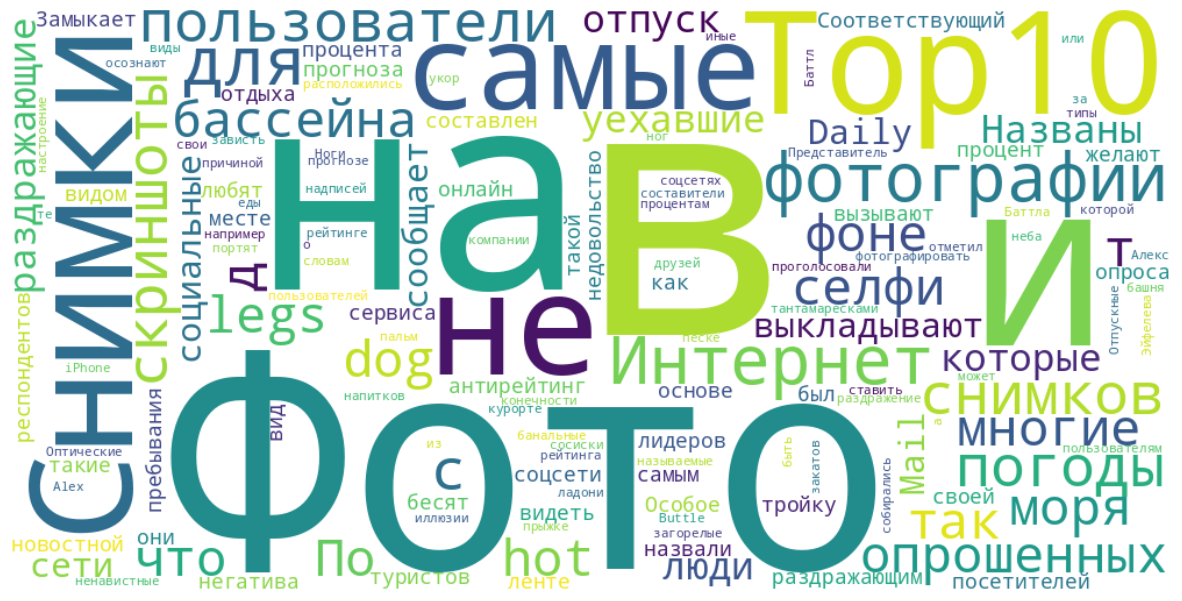

In [21]:
from matplotlib import pyplot as plt

word_cloud(df['text'].iloc[0], summarizer)

Посмотрим на исходную статью и на то, что получится в результате простой абстрактивной суммаризации

In [22]:
print ("The Actual length of the article is : ", len(df['text'].iloc[0]))
df['text'].iloc[0]

The Actual length of the article is :  1470


'Названы самые раздражающие фотографии, которые уехавшие в отпуск люди выкладывают в социальные сети, сообщает The Daily Mail. Соответствующий антирейтинг был составлен на основе опроса посетителей онлайн-сервиса для туристов Top10.com. Интернет-пользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети. Особое недовольство вызывают селфи, они бесят 44 процента респондентов. Замыкает тройку лидеров негатива такой вид фото, как hot dog legs (многие любят фотографировать свои загорелые конечности на фоне моря, бассейна и т.д.). «Ноги-сосиски» в соцсетях портят настроение 32 процентам опрошенных. Самые ненавистные для пользователей типы снимков друзей расположились в рейтинге Top10.com так:\n Скриншоты из iPhone о прогнозе погоды на курорте \n Отпускные селфи\n Снимки ног на фоне моря, бассейна и т.д. (так называемые hot dog legs)\n Фотографии в прыжке\n О

In [25]:
print ("The length of the summarized article is : ", len(summaries[0]))
summaries[0]

The length of the summarized article is :  558


'так называемые hot dog legs\n Фотографии в прыжке\n Оптические иллюзии например Эйфелева башня на ладони\n Фото надписей на песке\n Фото с тантамаресками\n Снимки закатов\n Фото неба и пальм\n Фото напитков и еды\n Представитель Top10com Алекс Баттл Alex Buttle отметил что составители рейтинга не собирались ставить «банальные снимки» в укор интернетпользователям.Интернетпользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети'

Как видите, этот метод работает недостаточно хорошо, попробуем его улучшить

## PageRank

Прежде чем приступить к алгоритму TextRank, есть еще один алгоритм, с которым мы должны ознакомиться - алгоритм PageRank. На самом деле, именно он вдохновил TextRank! PageRank используется в основном для ранжирования веб-страниц в результатах онлайн-поиска. Давайте быстро познакомимся с основами этого алгоритма на примере.

![](./images/Pagerank.png)

Предположим, у нас есть 4 веб-страницы — w1, w2, w3 и w4. Эти страницы содержат ссылки, указывающие друг на друга. Некоторые страницы могут не иметь ссылок - их называют висячими страницами.

![](./images/webpages.webp)

Веб-страница w1 имеет ссылки, ведущие на w2 и w4.  
w2 имеет ссылки на w3 и w1.  
w4 имеет ссылки только на веб-страницу w1.  
w3 не имеет ссылок и поэтому будет называться висячей страницей.  
Для того чтобы ранжировать эти страницы, нам необходимо вычислить оценку, называемую оценкой PageRank. Эта оценка является вероятностью того, что пользователь посетит эту страницу.

Для отображения вероятностей перехода пользователей с одной страницы на другую, мы создадим квадратную матрицу M, имеющую n строк и n столбцов, где n - количество веб-страниц.

![](./images/m_matrix.webp)

Каждый элемент этой матрицы обозначает вероятность перехода пользователя с одной веб-страницы на другую. Например, выделенная ниже ячейка содержит вероятность перехода с w1 на w2.

![](./images/transition_probability.webp)

Инициализация вероятностей осуществляется следующим способом:

Вероятность перехода со страницы i на страницу j, то есть M[ i ][ j ], инициализируется как 1/(количество уникальных ссылок на веб-странице wi).  
Если между страницей i и j нет ссылки, то вероятность будет инициализирована как 0.  
Если пользователь попал на висячую страницу, то предполагается, что он с равной вероятностью может перейти на любую страницу.   Следовательно, M[ i ][ j ] будет инициализирована как 1/(количество веб-страниц).  
Таким образом, в нашем случае матрица M будет инициализирована следующим образом:  

![](./images/final_matrix.webp)

Перейдем к описанию работы алгоритма PageRank

## TextRank

Опишем сходства между этими двумя алгоритмами:

Вместо веб-страниц мы используем предложения.  
Сходство между любыми двумя предложениями используется как эквивалент вероятности перехода между веб-страницами.  
Оценки сходства хранятся в квадратной матрице, аналогичной матрице M, используемой в PageRank.

Первым шагом будет конкатенация всего текста, содержащегося в статьях.  
Затем текст разделяется на отдельные предложения.  
На следующем шаге мы построим векторное представление для каждого предложения.  
Затем рассчитываются и сохраняются в матрице схожести между векторами предложений.  
Матрица схожести затем преобразуется в граф, с предложениями в качестве вершин и оценками схожести в качестве рёбер, для расчёта ранга предложений.  
Наконец, определённое количество предложений с наивысшим рангом формирует окончательное резюме.  

Данный алгоритм позволяет нам составить суммаризироанное предсталение не только для одного текста, но и для целой группы текстов. Далее мы посмотрим как можно реализовать оба этих варианта

### Суммаризация группы статей

Ограничим количество рассматриваемых статей, чтобы ограничить время вывполнения нашего Jupyter-notebook`а

In [26]:
from nltk.tokenize import sent_tokenize
import networkx as nx
import torch
from transformers import AutoTokenizer, AutoModel

In [27]:
n_articles_to_summarize = 1000

texts = df['text'].iloc[:n_articles_to_summarize]

sentences = [sent_in_single_text for single_text in texts for sent_in_single_text in sent_tokenize(single_text)]  # flattened sent-ces

print(len(sentences))
sentences[:10]

12723


['Названы самые раздражающие фотографии, которые уехавшие в отпуск люди выкладывают в социальные сети, сообщает The Daily Mail.',
 'Соответствующий антирейтинг был составлен на основе опроса посетителей онлайн-сервиса для туристов Top10.com.',
 'Интернет-пользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети.',
 'Особое недовольство вызывают селфи, они бесят 44 процента респондентов.',
 'Замыкает тройку лидеров негатива такой вид фото, как hot dog legs (многие любят фотографировать свои загорелые конечности на фоне моря, бассейна и т.д.).',
 '«Ноги-сосиски» в соцсетях портят настроение 32 процентам опрошенных.',
 'Самые ненавистные для пользователей типы снимков друзей расположились в рейтинге Top10.com так:\n Скриншоты из iPhone о прогнозе погоды на курорте \n Отпускные селфи\n Снимки ног на фоне моря, бассейна и т.д.',
 '(так называемые hot dog le

In [28]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer).shape)

(312,)


In [31]:
sim_mat = np.zeros([len(sentences), len(sentences)])

In [32]:
sentence_vectors = [embed_bert_cls(sent, model, tokenizer) for sent in tqdm(sentences)]
len(sentence_vectors)

  0%|          | 0/12723 [00:00<?, ?it/s]

12723

In [37]:
def build_similarity_matrix(sentences, embed_func):
    return cosine_similarity([embed_bert_cls(sent, model, tokenizer) for sent in tqdm(sentences)])

In [33]:
%%time
sim_mat = cosine_similarity(sentence_vectors)

CPU times: user 2.54 s, sys: 3.99 s, total: 6.53 s
Wall time: 282 ms


В качестве альтернативы, можете попробовать посмотреть на другой способ вычисления похожих векторов 

In [48]:
# def sentence_similarity(sent1,sent2, embed_func):  
#     A = embed_func([sent1])[0]
#     B = embed_func([sent2])[0]
#     return 1 - (np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))  # if using normalization ater BERT you can delete np.linalg.norm

Замечательная библиотека NetworkX содержит в себе реализацию популярного алгоритма PageRank, поэтому просто воспользуемся готовой реализацией для своей задачи

In [35]:
%%time

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

CPU times: user 4min 17s, sys: 11.3 s, total: 4min 29s
Wall time: 4min 28s


выведем наиболее важные предложения из всех текстов, полученные в результате суммаризации, а также выведем несколько оригинальных текстов

In [104]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
for i in range(15):
    print(ranked_sentences[i][1])
    print('\n\n')

Как сообщается на официальной странице устроителей из Центра арктического туризма «Грумант» в Facebook, путешественникам не потребуется норвежская виза благодаря тому, что туристы доберутся до архипелага чартером, а не через Осло.



Ранее в феврале сообщалось, что практически все отели марокканского курортного города Агадир перейдут на систему обслуживания «все включено» ради российских туристов.



Ранее в феврале сообщалось, что практически все отели марокканского курортного города Агадир перейдут на систему обслуживания «все включено» ради российских туристов.



19 ноября сообщалось, что российские туроператоры возобновили продажу путевок в Египет.



19 ноября сообщалось, что российские туроператоры возобновили продажу путевок в Египет.



Российских туристов, которые не имеют вид на жительства в Белоруссии, в Египет не выпускают», — приводит издание слова представителя компании «Тайм-Вояж».



Рейс был выполнен из чилийского Пунта-Аренаса», — рассказал представитель перевозчика.

In [91]:
for i in range(5):
    print(f"Article {i + 1}")
    print(df.text.iloc[i])
    print('\n\n', "*" * 120, '\n\n')

Article 1
Названы самые раздражающие фотографии, которые уехавшие в отпуск люди выкладывают в социальные сети, сообщает The Daily Mail. Соответствующий антирейтинг был составлен на основе опроса посетителей онлайн-сервиса для туристов Top10.com. Интернет-пользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети. Особое недовольство вызывают селфи, они бесят 44 процента респондентов. Замыкает тройку лидеров негатива такой вид фото, как hot dog legs (многие любят фотографировать свои загорелые конечности на фоне моря, бассейна и т.д.). «Ноги-сосиски» в соцсетях портят настроение 32 процентам опрошенных. Самые ненавистные для пользователей типы снимков друзей расположились в рейтинге Top10.com так:
 Скриншоты из iPhone о прогнозе погоды на курорте 
 Отпускные селфи
 Снимки ног на фоне моря, бассейна и т.д. (так называемые hot dog legs)
 Фотографии в прыжк

### Применим TextRank для суммаризация единичного текста

In [41]:
def generate_summary(text, top_n, embed_func):
    summarize_text = []  
    sentences = [sent_in_single_text for sent_in_single_text in sent_tokenize(text)]  
    sentence_similarity_matrix = build_similarity_matrix(sentences, embed_func)  
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph) 
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    for i in range(top_n):
        summarize_text.append(ranked_sentences[i][1]) 
    return " ".join(summarize_text)

In [45]:
summarized_text = generate_summary(df['text'].iloc[0], top_n=5, embed_func=embed_bert_cls)
print(len(summarized_text))
print(summarized_text)

  0%|          | 0/9 [00:00<?, ?it/s]

1057
Самые ненавистные для пользователей типы снимков друзей расположились в рейтинге Top10.com так:
 Скриншоты из iPhone о прогнозе погоды на курорте 
 Отпускные селфи
 Снимки ног на фоне моря, бассейна и т.д. Интернет-пользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети. Замыкает тройку лидеров негатива такой вид фото, как hot dog legs (многие любят фотографировать свои загорелые конечности на фоне моря, бассейна и т.д.). (так называемые hot dog legs)
 Фотографии в прыжке
 Оптические иллюзии (например, Эйфелева башня на ладони)
 Фото надписей на песке
 Фото с тантамаресками
 Снимки закатов
 Фото неба и пальм
 Фото напитков и еды
 Представитель Top10.com Алекс Баттл (Alex Buttle) отметил, что составители рейтинга не собирались ставить «банальные снимки» в укор интернет-пользователям. Названы самые раздражающие фотографии, которые уехавшие в отпус

In [46]:
print(len(df['text'].iloc[0]))
print(df['text'].iloc[0])

1470
Названы самые раздражающие фотографии, которые уехавшие в отпуск люди выкладывают в социальные сети, сообщает The Daily Mail. Соответствующий антирейтинг был составлен на основе опроса посетителей онлайн-сервиса для туристов Top10.com. Интернет-пользователи назвали самым раздражающим видом снимков с отдыха скриншоты прогноза погоды в месте пребывания — 51 процент опрошенных не желают видеть такие фото в своей новостной ленте в соцсети. Особое недовольство вызывают селфи, они бесят 44 процента респондентов. Замыкает тройку лидеров негатива такой вид фото, как hot dog legs (многие любят фотографировать свои загорелые конечности на фоне моря, бассейна и т.д.). «Ноги-сосиски» в соцсетях портят настроение 32 процентам опрошенных. Самые ненавистные для пользователей типы снимков друзей расположились в рейтинге Top10.com так:
 Скриншоты из iPhone о прогнозе погоды на курорте 
 Отпускные селфи
 Снимки ног на фоне моря, бассейна и т.д. (так называемые hot dog legs)
 Фотографии в прыжке
 Оп

Ниже представлен граф похожих предложений, которые превышают пороговое значение, и то, как они связаны в двумерном пространстве.  
Порог выбран условно

In [119]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx
from bokeh.io import output_notebook, show, save

output_notebook()

g = nx.Graph()

for i in range(100):
    for j in range(100):
        if sim_mat_2[i][j] >=0.9:
            g.add_edge(i, j)

HOVER_TOOLTIPS = [("sent_tok", "@index")]
plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1))

network_graph = from_networkx(g, networkx.spring_layout, scale=7, center=(0, 0))
network_graph.node_renderer.glyph = Circle(size=15,fill_color='green')
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
plot.renderers.append(network_graph)
show(plot)

Loading BokehJS ...

## Изучим обучение моделей с разной точностью

In [1]:
import os
import os.path as op
import time
from typing import Tuple

from datasets import load_dataset
from lightning import Fabric
import torch
from torch.utils.data import DataLoader
import torchmetrics
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from watermark import watermark

In [2]:
import os
import sys
import tarfile
import time

import numpy as np
import pandas as pd
from packaging import version
from torch.utils.data import Dataset
from tqdm import tqdm
import urllib

Для начала импортируем пару необходимых функций, которые понадобятся нам в для работы с данными

In [3]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.0**2 * duration)
    percent = count * block_size * 100.0 / total_size

    sys.stdout.write(
        f"\r{int(percent)}% | {progress_size / (1024.**2):.2f} MB "
        f"| {speed:.2f} MB/s | {duration:.2f} sec elapsed"
    )
    sys.stdout.flush()


def download_dataset():
    source = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    target = "aclImdb_v1.tar.gz"

    if os.path.exists(target):
        os.remove(target)

    if not os.path.isdir("aclImdb") and not os.path.isfile("aclImdb_v1.tar.gz"):
        urllib.request.urlretrieve(source, target, reporthook)

    if not os.path.isdir("aclImdb"):

        with tarfile.open(target, "r:gz") as tar:
            tar.extractall()


def load_dataset_into_to_dataframe():
    basepath = "aclImdb"

    labels = {"pos": 1, "neg": 0}

    df = pd.DataFrame()

    with tqdm(total=50000) as pbar:
        for s in ("test", "train"):
            for l in ("pos", "neg"):
                path = os.path.join(basepath, s, l)
                for file in sorted(os.listdir(path)):
                    with open(os.path.join(path, file), "r", encoding="utf-8") as infile:
                        txt = infile.read()

                    if version.parse(pd.__version__) >= version.parse("1.3.2"):
                        x = pd.DataFrame(
                            [[txt, labels[l]]], columns=["review", "sentiment"]
                        )
                        df = pd.concat([df, x], ignore_index=False)

                    else:
                        df = df.append([[txt, labels[l]]], ignore_index=True)
                    pbar.update()
    df.columns = ["text", "label"]

    np.random.seed(0)
    df = df.reindex(np.random.permutation(df.index))

    print("Class distribution:")
    np.bincount(df["label"].values)

    return df


def partition_dataset(df):
    df_shuffled = df.sample(frac=1, random_state=1).reset_index()

    df_train = df_shuffled.iloc[:35_000]
    df_val = df_shuffled.iloc[35_000:40_000]
    df_test = df_shuffled.iloc[40_000:]

    df_train.to_csv("train.csv", index=False, encoding="utf-8")
    df_val.to_csv("val.csv", index=False, encoding="utf-8")
    df_test.to_csv("test.csv", index=False, encoding="utf-8")


class IMDBDataset(Dataset):
    def __init__(self, dataset_dict, partition_key="train"):
        self.partition = dataset_dict[partition_key]

    def __getitem__(self, index):
        return self.partition[index]

    def __len__(self):
        return self.partition.num_rows

Как мы рассматривали на лекции, применяя обучение моделей с разной точностью, мы можем ускорить обучение моделей, не сильно проигрывая в качестве, а иногда и вовсе получая более качественную модель

Если вы запускаете следующий код на GPU, поддерживающем тензорные ядра(tensor cores), вы можете настроить точность для матричных умножений. Если мы хотим пожертвовать некоторой точностью ради производительности (как описано в документации PyTorch [здесь](https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html)), вы также можете установить любое из следующих значений:
- highest
- high
- medium

In [4]:
torch.set_float32_matmul_precision("high")

In [5]:
torch.cuda.is_bf16_supported()

True

In [6]:
torch.set_printoptions(precision=60)
torch.tensor(1/3, dtype=torch.float64)

tensor(0.333333333333333314829616256247390992939472198486328125000000,
       dtype=torch.float64)

In [7]:
torch.tensor(1/3, dtype=torch.float32)

tensor(0.333333343267440795898437500000000000000000000000000000000000)

In [8]:
torch.tensor(1/3, dtype=torch.float16)

tensor(0.333251953125000000000000000000000000000000000000000000000000,
       dtype=torch.float16)

In [9]:
torch.tensor(10**6, dtype=torch.float32)

tensor(1000000.)

In [10]:
torch.tensor(10**6, dtype=torch.float16)

tensor(inf, dtype=torch.float16)

In [11]:
torch.finfo(torch.float32)

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

In [12]:
torch.finfo(torch.float16)

finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)

In [13]:
torch.finfo(torch.bfloat16)

finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)

In [14]:
def train(num_epochs, model, optimizer, train_loader, val_loader, fabric):

    for epoch in range(num_epochs):
        train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(fabric.device)

        model.train()
        for batch_idx, batch in enumerate(train_loader):
            model.train()

            # For non-Fabric PyTorch:
            for s in ["input_ids", "attention_mask", "label"]:
               batch[s] = batch[s].to(model.device)

            ### FORWARD AND BACK PROP   
            outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["label"]) 
            optimizer.zero_grad()
            
            # For non-Fabric PyTorch:
            #outputs["loss"].backward()
            fabric.backward(outputs["loss"])

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 300:
                print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {outputs['loss']:.4f}")

            model.eval()
            with torch.no_grad():
                predicted_labels = torch.argmax(outputs["logits"], 1)
                train_acc.update(predicted_labels, batch["label"])

        ### MORE LOGGING
        model.eval()
        with torch.no_grad():
            val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(fabric.device)
            for batch in val_loader:

                # For non-Fabric PyTorch:
                for s in ["input_ids", "attention_mask", "label"]:
                   batch[s] = batch[s].to(model.device)
                outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["label"])
                predicted_labels = torch.argmax(outputs["logits"], 1)
                val_acc.update(predicted_labels, batch["label"])

            print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Train acc.: {train_acc.compute()*100:.2f}% | Val acc.: {val_acc.compute()*100:.2f}%")
            train_acc.reset(), val_acc.reset()

In [15]:
def init_training():
    print(watermark(packages="torch,lightning,transformers", python=True))
    print("Torch CUDA device -> ", torch.cuda.get_device_name())
    print("Torch CUDA device memory available -> ", torch.cuda.get_device_properties(0).total_memory)
    
    torch.manual_seed(123)

    ##########################
    ### 1 Loading the Dataset
    ##########################
    download_dataset()
    df = load_dataset_into_to_dataframe()
    if not (op.exists("train.csv") and op.exists("val.csv") and op.exists("test.csv")):
        partition_dataset(df)

    imdb_dataset = load_dataset(
        "csv",
        data_files={
            "train": "train.csv",
            "validation": "val.csv",
            "test": "test.csv",
        },
    )
    return imdb_dataset

In [16]:
def prepare_data(imdb_dataset) -> Tuple[DataLoader]:

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    print("Tokenizer input max length:", tokenizer.model_max_length, flush=True)
    print("Tokenizer vocabulary size:", tokenizer.vocab_size, flush=True)

    print("Tokenizing ...", flush=True)
    
    def tokenize_text(batch):
        return tokenizer(batch["text"], truncation=True, padding=True)
        
    imdb_tokenized = imdb_dataset.map(tokenize_text, batched=True, batch_size=None)
    del imdb_dataset
    imdb_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    #########################################
    ### 3 Set Up DataLoaders
    #########################################

    train_dataset = IMDBDataset(imdb_tokenized, partition_key="train")
    val_dataset = IMDBDataset(imdb_tokenized, partition_key="validation")
    test_dataset = IMDBDataset(imdb_tokenized, partition_key="test")

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=12,
        shuffle=True, 
        num_workers=4,
        drop_last=True,
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=12,
        num_workers=4,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=12,
        num_workers=2,
        drop_last=True,
    )
    return train_loader, val_loader, test_loader

In [17]:
def prepare_model(dataloaders: Tuple[DataLoader, DataLoader, DataLoader], precision):
    fabric = Fabric(accelerator="cuda", devices=1, precision=precision)
    fabric.launch()
    
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2)

    # model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

    model, optimizer = fabric.setup(model, optimizer)
    train_loader, val_loader, test_loader = fabric.setup_dataloaders(*dataloaders)
    fabric.barrier()
    return fabric, model, optimizer

In [18]:
def start_training(fabric, model, optimizer, dataloaders: Tuple[DataLoader, DataLoader, DataLoader]):
    train_loader, val_loader, test_loader = dataloaders
    start = time.time()
    train(
        num_epochs=3,
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        fabric=fabric
    )

    end = time.time()
    elapsed = end-start
    print(f"Time elapsed {elapsed/60:.2f} min")

    with torch.no_grad():
        model.eval()
        test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(fabric.device)
        for batch in test_loader:

            for s in ["input_ids", "attention_mask", "label"]:
               batch[s] = batch[s].to(model.device)
            
            outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["label"])
            predicted_labels = torch.argmax(outputs["logits"], 1)
            test_acc.update(predicted_labels, batch["label"])

    print(f"Memory used: {torch.cuda.max_memory_reserved() / 1e9:.02f} GB")
    print(f"Test accuracy {test_acc.compute()*100:.2f}%")

In [19]:
def main(precision):
    print(f'Using {precision} precision')
    dataloaders = prepare_data(init_training()) 
    start_training(*prepare_model(dataloaders, precision), dataloaders)

![](./images/float32.png)

In [20]:
precision = "32-true"
main(precision)

Using 32-true precision
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.20.0

torch       : 2.0.1
lightning   : 2.2.0.post0
transformers: 4.33.0

Torch CUDA device ->  NVIDIA GeForce RTX 4080
Torch CUDA device memory available ->  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3494.22it/s]


Class distribution:
Tokenizer input max length: 512
Tokenizer vocabulary size: 30522
Tokenizing ...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0001/0003 | Batch 0000/2916 | Loss: 0.6892
Epoch: 0001/0003 | Batch 0300/2916 | Loss: 0.3850
Epoch: 0001/0003 | Batch 0600/2916 | Loss: 0.3668
Epoch: 0001/0003 | Batch 0900/2916 | Loss: 0.2629
Epoch: 0001/0003 | Batch 1200/2916 | Loss: 0.2789
Epoch: 0001/0003 | Batch 1500/2916 | Loss: 0.7048
Epoch: 0001/0003 | Batch 1800/2916 | Loss: 0.4392
Epoch: 0001/0003 | Batch 2100/2916 | Loss: 0.5657
Epoch: 0001/0003 | Batch 2400/2916 | Loss: 0.3215
Epoch: 0001/0003 | Batch 2700/2916 | Loss: 0.2677
Epoch: 0001/0003 | Train acc.: 89.85% | Val acc.: 92.05%
Epoch: 0002/0003 | Batch 0000/2916 | Loss: 0.1243
Epoch: 0002/0003 | Batch 0300/2916 | Loss: 0.0108
Epoch: 0002/0003 | Batch 0600/2916 | Loss: 0.0643
Epoch: 0002/0003 | Batch 0900/2916 | Loss: 0.1090
Epoch: 0002/0003 | Batch 1200/2916 | Loss: 0.0103
Epoch: 0002/0003 | Batch 1500/2916 | Loss: 0.0421
Epoch: 0002/0003 | Batch 1800/2916 | Loss: 0.0367
Epoch: 0002/0003 | Batch 2100/2916 | Loss: 0.0311
Epoch: 0002/0003 | Batch 2400/2916 | Loss: 

![](./images/mp-training.png)

In [20]:
precision = "16-mixed"
main(precision)

Using 16-mixed precision
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.20.0

torch       : 2.0.1
lightning   : 2.2.0.post0
transformers: 4.33.0

Torch CUDA device ->  NVIDIA GeForce RTX 4080
Torch CUDA device memory available ->  16857169920


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3474.03it/s]


Class distribution:
Tokenizer input max length: 512
Tokenizer vocabulary size: 30522
Tokenizing ...


Using 16-bit Automatic Mixed Precision (AMP)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0001/0003 | Batch 0000/2916 | Loss: 0.6891
Epoch: 0001/0003 | Batch 0300/2916 | Loss: 0.2548
Epoch: 0001/0003 | Batch 0600/2916 | Loss: 0.3144
Epoch: 0001/0003 | Batch 0900/2916 | Loss: 0.3898
Epoch: 0001/0003 | Batch 1200/2916 | Loss: 0.2798
Epoch: 0001/0003 | Batch 1500/2916 | Loss: 0.6727
Epoch: 0001/0003 | Batch 1800/2916 | Loss: 0.5373
Epoch: 0001/0003 | Batch 2100/2916 | Loss: 0.6455
Epoch: 0001/0003 | Batch 2400/2916 | Loss: 0.3745
Epoch: 0001/0003 | Batch 2700/2916 | Loss: 0.1814
Epoch: 0001/0003 | Train acc.: 89.87% | Val acc.: 91.83%
Epoch: 0002/0003 | Batch 0000/2916 | Loss: 0.0816
Epoch: 0002/0003 | Batch 0300/2916 | Loss: 0.0087
Epoch: 0002/0003 | Batch 0600/2916 | Loss: 0.0455
Epoch: 0002/0003 | Batch 0900/2916 | Loss: 0.1566
Epoch: 0002/0003 | Batch 1200/2916 | Loss: 0.0184
Epoch: 0002/0003 | Batch 1500/2916 | Loss: 0.0297
Epoch: 0002/0003 | Batch 1800/2916 | Loss: 0.0389
Epoch: 0002/0003 | Batch 2100/2916 | Loss: 0.0358
Epoch: 0002/0003 | Batch 2400/2916 | Loss: 

Очень интересные результаты мы получим, когда попробуем обучить модель в обычной разрядности FP16

![](./images/float16.png)

In [21]:
precision = "16-true"
main(precision)

Using 16-true precision
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.20.0

torch       : 2.0.1
lightning   : 2.2.0.post0
transformers: 4.33.0

Torch CUDA device ->  NVIDIA GeForce RTX 4080
Torch CUDA device memory available ->  16857169920


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3441.95it/s]


Class distribution:
Tokenizer input max length: 512
Tokenizer vocabulary size: 30522
Tokenizing ...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0001/0003 | Batch 0000/2916 | Loss: 0.6890
Epoch: 0001/0003 | Batch 0300/2916 | Loss: nan
Epoch: 0001/0003 | Batch 0600/2916 | Loss: nan
Epoch: 0001/0003 | Batch 0900/2916 | Loss: nan
Epoch: 0001/0003 | Batch 1200/2916 | Loss: nan
Epoch: 0001/0003 | Batch 1500/2916 | Loss: nan
Epoch: 0001/0003 | Batch 1800/2916 | Loss: nan
Epoch: 0001/0003 | Batch 2100/2916 | Loss: nan
Epoch: 0001/0003 | Batch 2400/2916 | Loss: nan
Epoch: 0001/0003 | Batch 2700/2916 | Loss: nan
Epoch: 0001/0003 | Train acc.: 49.87% | Val acc.: 50.80%
Epoch: 0002/0003 | Batch 0000/2916 | Loss: nan
Epoch: 0002/0003 | Batch 0300/2916 | Loss: nan
Epoch: 0002/0003 | Batch 0600/2916 | Loss: nan
Epoch: 0002/0003 | Batch 0900/2916 | Loss: nan
Epoch: 0002/0003 | Batch 1200/2916 | Loss: nan
Epoch: 0002/0003 | Batch 1500/2916 | Loss: nan
Epoch: 0002/0003 | Batch 1800/2916 | Loss: nan
Epoch: 0002/0003 | Batch 2100/2916 | Loss: nan
Epoch: 0002/0003 | Batch 2400/2916 | Loss: nan
Epoch: 0002/0003 | Batch 2700/2916 | Loss: nan


![](./images/bfloat16.png)

In [20]:
precision = "bf16-mixed"
main(precision)

Using bf16-mixed precision
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.20.0

torch       : 2.0.1
lightning   : 2.2.0.post0
transformers: 4.33.0

Torch CUDA device ->  NVIDIA GeForce RTX 4080
Torch CUDA device memory available ->  16857169920


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3489.41it/s]


Class distribution:
Tokenizer input max length: 512
Tokenizer vocabulary size: 30522
Tokenizing ...


Using bfloat16 Automatic Mixed Precision (AMP)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0001/0003 | Batch 0000/2916 | Loss: 0.6891
Epoch: 0001/0003 | Batch 0300/2916 | Loss: 0.3451
Epoch: 0001/0003 | Batch 0600/2916 | Loss: 0.3688
Epoch: 0001/0003 | Batch 0900/2916 | Loss: 0.2705
Epoch: 0001/0003 | Batch 1200/2916 | Loss: 0.2378
Epoch: 0001/0003 | Batch 1500/2916 | Loss: 0.5476
Epoch: 0001/0003 | Batch 1800/2916 | Loss: 0.4647
Epoch: 0001/0003 | Batch 2100/2916 | Loss: 0.7284
Epoch: 0001/0003 | Batch 2400/2916 | Loss: 0.2866
Epoch: 0001/0003 | Batch 2700/2916 | Loss: 0.2099
Epoch: 0001/0003 | Train acc.: 89.58% | Val acc.: 92.31%
Epoch: 0002/0003 | Batch 0000/2916 | Loss: 0.0771
Epoch: 0002/0003 | Batch 0300/2916 | Loss: 0.0429
Epoch: 0002/0003 | Batch 0600/2916 | Loss: 0.1002
Epoch: 0002/0003 | Batch 0900/2916 | Loss: 0.1254
Epoch: 0002/0003 | Batch 1200/2916 | Loss: 0.0808
Epoch: 0002/0003 | Batch 1500/2916 | Loss: 0.0383
Epoch: 0002/0003 | Batch 1800/2916 | Loss: 0.1023
Epoch: 0002/0003 | Batch 2100/2916 | Loss: 0.0659
Epoch: 0002/0003 | Batch 2400/2916 | Loss: 